# An Analysis of US House of Representatives Trading Activity

### By: Daniel Milton

## Summary of Findings

### Introduction
Here we will be diving into the current (117th) House of Representatives stock trades for the past two years. With help from the dataset provided by Timothy Carambat (https://housestockwatcher.com/api), the question I'm exploring is whether political parties in the House of Representatives have different or similiar trading activities. The dataset provides information such as the timeline of the transaction, ownership type, purchase type, and other details on the transaction. A key element missing from this dataset however, is each politicians political party which is essential in answering my question. In the following steps, I will be dissecting and analyzing my data to answer the question of whether there is a difference in stock trading behavior between political parties. I will use several exploratory data analysis methods to gauge and help answer my question.

### Cleaning and EDA
Cleaning:

Cleaning the data involved several steps. I first began by doing basic things such as converting the purchase/sold dates to pd.datetime. I then filled in all string values of '--' to np.NaN, which indicates a missing value. After this, I began the long process of matching every name in the House of Represenatives to their respective parties. I first began by getting the 116th house of representatives dataset from Kaggle. (https://www.kaggle.com/datasets/aavigan/house-of-representatives-congress-116) I could not find the 117th dataset in a clean csv so I started with this first to see how many matches I could get. I cleaned the names in the new data file using the name_cleaner function and I used a left merge with the original stock dataframe and the newly downloaded dataframe. I could see that many of the names were still returning null values for their parties so I went to look for more data. I then found the wiki page of the 117th House of Representatives (https://en.wikipedia.org/wiki/List_of_current_members_of_the_United_States_House_of_Representatives) and scraped its data into a dataframe. I then used a second merge and most of the remaining null parties were filled in. With the remaining names, I used a dictionary and a map function to fill them out.

EDA:

I first used univariate analysis to decipher political party purchasing activity. Here it appears that Democrats tend to make more stock trades, but at a lower average cost, while Republicans make fewer stock trades, but at a higher average cost. I then did a bivariate analysis to create a pivot table to analyze the relationship between political party and transaction ownership status, and found that Democrats are much more likely to purchase stock in their own name (0.785331 frequency) while Republicans are more likely to purchase stock in a dependents name (0.554974 frequency). I followed this up by creating a scatter plot between purchase amount and its type and found that purchases categorized as exchanges are usually costing the least. I finally finished my EDA by finding some aggregate statistics by grouping the party column with the amount column and finding the mean to return a table of the average stock purchase amount. Republicans had a mean purchase size of \\$40,233, while Democrats had a mean purchase size of \\$23,783. This told me clearly that Republicans tended to make bigger stock purchases. I found another statistic when I used groupby again and performed a sum on it and found that Democrats make the most stock purchases. Democrats made 9106 transactions, while Republicans made 5114 transactions.

### Assessment of Missingness
After looking at the newly cleaned dataframe, I found out that the column 'owner' contains the most missing values at 6669. The ticker column also has 1147 missing values, but we can count this as trivial since a quick look at the data shows that not all purchases are public companies with stock tickers. The question to ask was whether the missing values in the Owner column where NMAR or MAR. To find this out I created a permutation test to see whether the Owner column's missing values depended on other columns. I used the purmutation test on the columns: cap_gains_over_200_usd, amount, and type. I got p-values of: 0.00, 0.008, 0.00 respectively. With these values, we can reject the null in every case and accept the alternative that yes, whether the Owner values are null or not, are significantly dependent on these columns.

This doesn't affect our ability to answer the question we are trying to answer, since we are mostly looking at the relationships between politial party and transaction activity.

### Hypothesis Test
The question I decided to do a hypothesis test on was to confirm whether Republicans made bigger transactions on average than Democrats. 

#### Null hypothesis: Republican Mean Trade <= Democrat Mean Trade

#### Alternative hypothesis: Republican Mean Trade > Democrat Mean Trade

#### Test statistic: Difference in means

#### Significance Level: .05 

I chose this test statistic because a difference in means would be the best indicator to help us decipher whether there is a significant difference between size of trades among political parties. I then performed a permutation test on the 'party' and 'amount' columns, simulated 500 times to receive a P-Value of .002. Since the P-Value < Significance Level, we can reject the null and accept the alternative that Republicans do on average, make larger transactions than Democrats

## Code and Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import requests
import lxml
import bs4

## Cleaning and EDA

### Loading in data

In [2]:
# loading in the orginal df and the 116th house of rep. kaggle df
# converted dates to pd.dateime and filled in '--' with np.NaN
stocks = pd.read_csv('stocks.csv')
partyfinder = pd.read_csv('political_party.csv')
stocks['disclosure_date'] = pd.to_datetime(stocks['disclosure_date'])
stocks.replace(to_replace = '--', value = np.NaN, inplace = True)
partyfinder.head()

,name_id,name,state,url,chamber,current_party,committee_assignments
0,A000374,ralph-abraham,Louisiana,https://www.congress.gov/member/ralph-abraham/...,House,Republican,"['Agriculture', 'Armed Services']"
1,A000370,alma-adams,North Carolina,https://www.congress.gov/member/alma-adams/A00...,House,Democratic,"['Agriculture', 'Education and Labor', 'Financ..."
2,A000055,robert-aderholt,Alabama,https://www.congress.gov/member/robert-aderhol...,House,Republican,['Appropriations']
3,A000371,pete-aguilar,California,https://www.congress.gov/member/pete-aguilar/A...,House,Democratic,"['Appropriations', 'House Administration']"
4,A000372,rick-allen,Georgia,https://www.congress.gov/member/rick-allen/A00...,House,Republican,"['Agriculture', 'Education and Labor']"


### Name cleaning function I used to catch unique names and make names between two dataframes as similiar as possible in order for a clean merge to occur

In [3]:
# This function uses .replace() and .lower() to replace
# many of the unique values and standardize all the strings to lowercase
# letters
def name_cleaner(x):
    z = x.replace('Hon. Donald Sternoff Honorable Beyer', 'Don Beyer')
    w = z.replace('Hon. Charles J. "Chuck" Fleischmann', 'Chuck Fleischmann')
    x = w.replace('Hon. Richard W. Allen', 'Rick W. Allen')
    v = x.replace('Hon. Neal Patrick MD, Facs Dunn', 'Neal Dunn')
    y = v.replace('Rohit', 'Ro')
    a = y.replace('Hon. ', '')
    b = a.replace('None ', '')
    c = b.replace('Mr. ', '')
    d = c.replace(' ', '-')
    e = d.replace('Mr. ', '')
    one = e.replace('Robert', 'Rob')
    two = one.replace('Christopher', 'Chris')
    three = two.replace('Daniel', 'Dan')
    four = three.replace('Patrick', 'Pat')     
    f = four.split('-')
    if len(f) > 2:
        g = '-'.join([f[0], f[2]])
    else:
        g = '-'.join(f)
    return g.lower()

### This function cleans the amount column to something I could use as numerical data

In [4]:
# This replaces most of the strings that stop 
# the amount converting to ints, and it also splits the amount 
# range and grabs the first int in the range to be used in analysis
def amount_cleaner(x):
    y = x.replace('$', '')
    a = y.replace(',', '')
    b = a.replace(' +', '')
    new = b.split('-')
    if (int(new[0]) % 2) == 0:
        return int(new[0])
    else:
        return int(new[0]) - 1

### Simple function to change a string in party column to make all the party strings the same

In [5]:
# replaces a string
def party_cleaner(x):
    if x == 'Democratic':
        return 'Democrat'
    else:
        return x

### Applying cleaning functions and changing column name in prepartion for first merge with Kaggle dataset

In [6]:
# applying the name_cleaner functions and renaming columns in preparation for merge
partyfinder['name'] = partyfinder['name'].apply(name_cleaner)
stocks['representative'] = stocks['representative'].apply(name_cleaner)
stocks.rename({'representative': 'name'}, axis = 1, inplace=True)

### First left merge

In [7]:
# merged original df and kaggle df
merged = stocks.merge(partyfinder, on = 'name', how = 'left')
merged.head()

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,name,district,ptr_link,cap_gains_over_200_usd,name_id,state,url,chamber,current_party,committee_assignments
0,2021,2021-10-04,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",virginia-foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,F000450,North Carolina,https://www.congress.gov/member/virginia-foxx/...,House,Republican,"['Education and Labor', 'Oversight and Reform']"
1,2021,2021-10-04,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",virginia-foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,F000450,North Carolina,https://www.congress.gov/member/virginia-foxx/...,House,Republican,"['Education and Labor', 'Oversight and Reform']"
2,2021,2021-10-04,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",virginia-foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,F000450,North Carolina,https://www.congress.gov/member/virginia-foxx/...,House,Republican,"['Education and Labor', 'Oversight and Reform']"
3,2021,2021-10-04,2021-09-28,joint,PM,Phillip Morris International Inc,purchase,"$15,001 - $50,000",virginia-foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,F000450,North Carolina,https://www.congress.gov/member/virginia-foxx/...,House,Republican,"['Education and Labor', 'Oversight and Reform']"
4,2021,2021-10-04,2021-09-17,self,BLK,BlackRock Inc,sale_partial,"$1,001 - $15,000",alan-lowenthal,CA47,https://disclosures-clerk.house.gov/public_dis...,False,L000579,California,https://www.congress.gov/member/alan-lowenthal...,House,Democratic,"['Natural Resources', 'Transportation and Infr..."


### Request to scrape Wikipedia page for more politicians political parties

In [8]:
## requesting to scrape the wikipedia article with 117th(current) 
## house of representative members I then grabbed the table containing 
# all the names/parties
r = requests.get('https://en.wikipedia.org/wiki/List_of_current_members_of_the_United_States_House_of_Representatives')
soup = bs4.BeautifulSoup(r.text, features='lxml')
links = soup.find('table', attrs ={'id':'votingmembers'})

### This is a scraping function that returns each polticians name and their respective party

In [9]:
# This function works by iterating through the table 
# grabbed in the links variable in the above cell and grabbing table data. 
# The reason why I used the try except code is because 
# some of the cells in the table contained different information other than
# the politician and cause and error to be raised.
def partyAndName(text):
    names = []
    party = []
    tab = text.find_all('tr')[1:]
    for i in tab:
        try:
            cells = i.find_all('td')
            party.append(cells[2].text.strip('\n'))
            names.append(cells[0].text.strip('\n').strip(' '))
        except IndexError:
            continue
    return names, party

### This code returns a new dataframe from all the data scrapped from the Wikipedia page

In [10]:
# Run the above function and create a dataframe with the newly
# scraped data
names, party = partyAndName(links)
data = [names, party]
new_df = pd.DataFrame()
new_df['name'] = data[0]
new_df['party'] = data[1]
new_df['name'] = new_df['name'].apply(name_cleaner)
new_df.head()

,name,party
0,jerry-carl,Republican
1,barry-moore,Republican
2,mike-rogers,Republican
3,rob-aderholt,Republican
4,mo-brooks,Republican


### The 2nd merge and catching the rest of the unique names. I used a map function for the remaining names not found in the previous merges and simply googled their political party.

In [11]:
## Here I performed the final merge and used a dictionary to map
## all the remaining values that weren't caught in the first two merges.
## I used google for the remaining unique names
merged2 = stocks.merge(new_df, on = 'name', how = 'left')
merged3 = merged2.merge(partyfinder, on = 'name', how = 'left')
new = {'k.-conaway':'Republican', 
       'michael-garcia':'Republican',
       'michael-gallagher':'Republican',
      'mrs.-taylor':'Republican',
      'james-hon':'Republican',
      'james-banks':'Republican',
      'nicholas-taylor':'Libertarian',
      'rob-"bobby"':'Democrat',
      'ashley-arenholz':'Republican'}
merged3.party.fillna(merged3.current_party, inplace=True)
merged3['current_party'] = merged3['name'].map(new)
merged3.party.fillna(merged3.current_party, inplace=True)
merged3 = merged3[merged3.party != 'Libertarian']
merged3 = merged3[merged3.party != 'Independent']
merged3.head()

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,name,district,ptr_link,cap_gains_over_200_usd,party,name_id,state,url,chamber,current_party,committee_assignments
0,2021,2021-10-04,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",virginia-foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,Republican,F000450,North Carolina,https://www.congress.gov/member/virginia-foxx/...,House,NaN,"['Education and Labor', 'Oversight and Reform']"
1,2021,2021-10-04,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",virginia-foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,Republican,F000450,North Carolina,https://www.congress.gov/member/virginia-foxx/...,House,NaN,"['Education and Labor', 'Oversight and Reform']"
2,2021,2021-10-04,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",virginia-foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,Republican,F000450,North Carolina,https://www.congress.gov/member/virginia-foxx/...,House,NaN,"['Education and Labor', 'Oversight and Reform']"
3,2021,2021-10-04,2021-09-28,joint,PM,Phillip Morris International Inc,purchase,"$15,001 - $50,000",virginia-foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,Republican,F000450,North Carolina,https://www.congress.gov/member/virginia-foxx/...,House,NaN,"['Education and Labor', 'Oversight and Reform']"
4,2021,2021-10-04,2021-09-17,self,BLK,BlackRock Inc,sale_partial,"$1,001 - $15,000",alan-lowenthal,CA47,https://disclosures-clerk.house.gov/public_dis...,False,Democratic,L000579,California,https://www.congress.gov/member/alan-lowenthal...,House,NaN,"['Natural Resources', 'Transportation and Infr..."


### Here I dropped all irrelevant columns that won't help answer my question

In [12]:
merged3.drop(columns=['name_id', 'ptr_link', 'url', 'chamber', \
                      'current_party', 'committee_assignments'], inplace = True)
merged3.head()

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,name,district,cap_gains_over_200_usd,party,state
0,2021,2021-10-04,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",virginia-foxx,NC05,False,Republican,North Carolina
1,2021,2021-10-04,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",virginia-foxx,NC05,False,Republican,North Carolina
2,2021,2021-10-04,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",virginia-foxx,NC05,False,Republican,North Carolina
3,2021,2021-10-04,2021-09-28,joint,PM,Phillip Morris International Inc,purchase,"$15,001 - $50,000",virginia-foxx,NC05,False,Republican,North Carolina
4,2021,2021-10-04,2021-09-17,self,BLK,BlackRock Inc,sale_partial,"$1,001 - $15,000",alan-lowenthal,CA47,False,Democratic,California


### One final clean to make sure I catch all non-wanted data forms

In [13]:
merged3['amount'] = merged3['amount'].apply(amount_cleaner)
merged3['party'] = merged3['party'].apply(party_cleaner)
merged3.head()

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,name,district,cap_gains_over_200_usd,party,state
0,2021,2021-10-04,2021-09-27,joint,BP,BP plc,purchase,1000,virginia-foxx,NC05,False,Republican,North Carolina
1,2021,2021-10-04,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,1000,virginia-foxx,NC05,False,Republican,North Carolina
2,2021,2021-10-04,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,15000,virginia-foxx,NC05,False,Republican,North Carolina
3,2021,2021-10-04,2021-09-28,joint,PM,Phillip Morris International Inc,purchase,15000,virginia-foxx,NC05,False,Republican,North Carolina
4,2021,2021-10-04,2021-09-17,self,BLK,BlackRock Inc,sale_partial,1000,alan-lowenthal,CA47,False,Democrat,California


### Republican Purchases (Univariate Analysis)

<ipython-input-14-9e138796626c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  republicans['add'] = ones


Text(0.5, 0, 'Amount ($)')

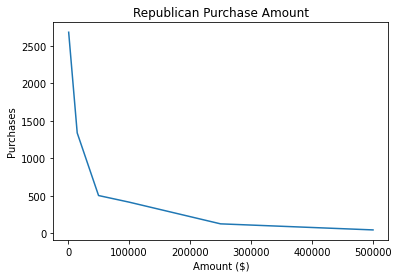

In [14]:
## Here I filtered the dataframe to only have Republican politicians and I then
# made an array of ones, so I had a way of adding up the 
# frequency of each purchase amount. I then plotted
republicans = merged3[merged3['party'] == 'Republican']
ones = np.ones(len(republicans))
republicans['add'] = ones
ax = republicans.groupby('amount')['add'].sum()[:-3].plot(x = 'amount', \
                                        title='Republican Purchase Amount')
ax.set_ylabel('Purchases')
ax.set_xlabel('Amount ($)')

### Democrat Purchases (Univariate Analysis)

<ipython-input-15-60e7ba6fa72a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  democrats['add'] = ones


Text(0.5, 0, 'Amount ($)')

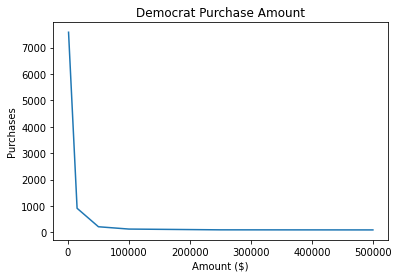

In [15]:
## Here I filtered the dataframe to only have Democrat politicians and I then
# made an array of ones, so I had a way of adding up the 
# frequency of each purchase amount. I then plotted
democrats = merged3[merged3['party'] == 'Democrat']
ones = np.ones(len(democrats))
democrats['add'] = ones
ax = democrats.groupby('amount')['add'].sum()[:-2].plot(x = 'amount', \
                                        title='Democrat Purchase Amount')
ax.set_ylabel('Purchases')
ax.set_xlabel('Amount ($)')

### Bivariate Analysis

In [16]:
# Here I created a pivot table to see the relationship between party and 
# ownership status of a stock transaction
pivot = (
   merged3
    .pivot_table(index='party', columns='owner', values=None, \
                 aggfunc='size')
    .fillna(0)
    .apply(lambda x: x / x.sum())
)
pivot

owner,dependent,joint,self
party,,,
Democrat,0.445026,0.6301,0.785331
Republican,0.554974,0.3699,0.214669


### Creating a scatterplot to see the relationship between purchase amount, and type of purchase

<AxesSubplot:title={'center':'Democrat Purchase Amount'}, xlabel='amount', ylabel='type'>

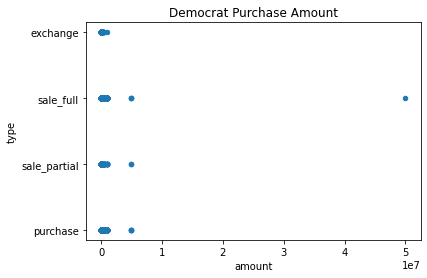

In [17]:
# Creating a scatter plot between amount and type
merged3.plot(kind='scatter', x='amount', y='type', \
             title='Democrat Purchase Amount')

### Which party makes bigger purchases? (Aggregate Statistics)

In [18]:
# I used the groupby function to group all the parties together, 
# and find their respective mean stock purchase amount.
new_col = np.ones(len(merged3))
merged3['add'] = new_col
purchase_size = merged3.groupby('party')['amount'].mean()
purchase_size.drop(columns=['disclosure_year', 'cap_gains_over_200_usd'], \
                   inplace = True)

In [19]:
purchase_size

party
Democrat      23783.329673
Republican    40233.085647
Name: amount, dtype: float64

### Which party makes more purchases overall? (Aggregate Statistics)

In [20]:
overall_size = merged3.groupby(['party', 'amount']).sum()
overall_size.drop(columns=['disclosure_year', 'cap_gains_over_200_usd'], \
                  inplace = True)
overall_size.groupby('party').sum()

,add
party,
Democrat,9106.0
Republican,5114.0


## Assessment of Missingness

### I first started by counting the null values in the data frame

In [21]:
## Used is null and sum to count null values in df
merged3.isnull().sum(axis = 0)[:11]

disclosure_year              0
disclosure_date              0
transaction_date             0
owner                     6649
ticker                    1147
asset_description            4
type                         0
amount                       0
name                         0
district                     0
cap_gains_over_200_usd       0
dtype: int64

### I created a boolean column in the df indicating which rows contained a null value for the owner column

In [22]:
## Created and assigned data to new column
merged3['owner_missing'] = merged3['owner'].isna()

### Created and plotted a pivot table showing the proportions of whether the owner value is missing corresponding to its party

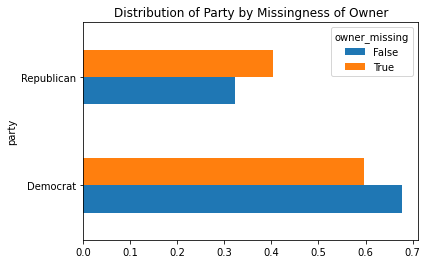

In [23]:
## Created pivot table and plotted
distributions = (
   merged3
    .pivot_table(index='party', columns='owner_missing', values=None, \
                 aggfunc='size')
    .fillna(0)
    .apply(lambda x: x / x.sum())
)
distributions.iloc[:15].plot(kind='barh', \
                             title='Distribution of Party by Missingness of Owner');

### My observed statistic

In [24]:
observed_tvd = distributions.diff(axis=1).iloc[:, -1].abs().sum() / 2
observed_tvd

0.08060913474385367

### I then created a function that I could input columns into, to quickly decipher whether the owner column is dependent on that certain column

In [25]:
def nmar(column, merged3):
    merged3['owner_missing'] = merged3['owner'].isna()
    distributions = (merged3
        .pivot_table(index=column, columns='owner_missing', \
                     values=None, aggfunc='size')
        .fillna(0).apply(lambda x: x / x.sum()))
    observed_tvd = distributions.diff(axis=1).iloc\
                            [:, -1].abs().sum() / 2
    

    shuffled = merged3.copy()[[column, 'owner_missing']]

    n_repetitions = 500
    tvds = []

    for i in range(n_repetitions):
        # Shuffling column
        shuffled[column] = np.random.permutation(shuffled[column])
    
        # Computing and storing the TVD
        pivoted = (
            shuffled
            .pivot_table(index=column, columns='owner_missing', \
                         values=None, aggfunc='size')
            .fillna(0).apply(lambda x: x / x.sum()))
    
        tvd = pivoted.diff(axis=1).iloc[:, -1].abs().sum() / 2
        tvds.append(tvd)

    pval = np.mean(tvds >= observed_tvd)
    pd.Series(tvds).plot(kind='hist', density=True, ec='w', bins=10, \
                         title=f'p-value: {pval}', label='Simulated TVDs')
    plt.axvline(x=observed_tvd, color='red', linewidth=4, label='Observed TVD')
    plt.legend();

### Owner missing depending on cap_gains_over_200_usd?

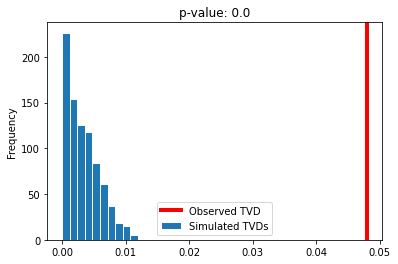

In [26]:
nmar('cap_gains_over_200_usd', merged3)

### Owner missing depending on amount?

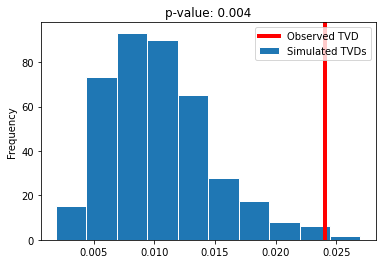

In [27]:
nmar('amount', merged3)

### Owner missing depending on type?

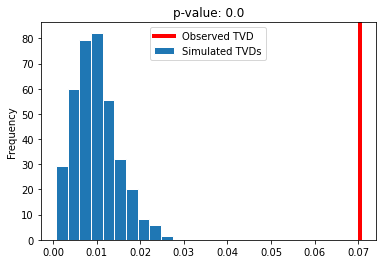

In [28]:
nmar('type', merged3)

## Hypothesis Testing

### Question: Do Republicans make bigger trades than Democrats?

#### Null hypothesis: Republican Mean Trade <= Democrat Mean Trade

#### Alternative hypothesis: Republican Mean Trade > Democrat Mean Trade

#### Test statistic: Difference in means


#### Significance Level: .05 


### The observed test statistic, which is the difference in purchase amount means between Democrats and Republicans

In [29]:
# Subtracted the means which was found earlier in the EDA section
observed_difference = (merged3.groupby('party')['amount'].mean().\
                       diff().iloc[-1])
observed_difference

16449.755974499618

### My simulation which will be ran 500 times under the null hypothesis

In [30]:
n_repetitions = 500

differences = []
for i in range(n_repetitions):
    
    # Shuffling
    shuffled_amount = (merged3['amount'].sample(frac=1).\
                       reset_index(drop=True))
    
    # Assigned shuffled column to dataframe
    shuffled = (merged3.assign(**{'Shuffled Amount': shuffled_amount}))
    
    # Computing test statistic
    group_means = (shuffled.groupby('party').mean().loc[:, 'Shuffled Amount'])
    
    difference = abs(group_means.diff().iloc[-1])
    
    # Appending result
    differences.append(difference)
    
differences[:5]

[11681.503006042225,
 7178.723361651544,
 6251.745911651229,
 3245.7454754343817,
 4382.5524886645]

### Plotting my results using a histogram

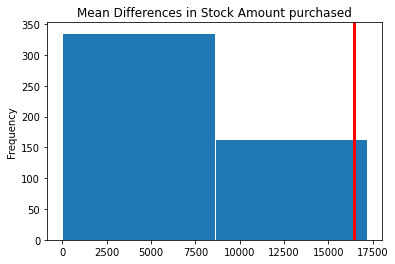

In [31]:
# Plotting my results using a histogram
title = 'Mean Differences in Stock Amount purchased'
pd.Series(differences).plot(kind='hist',  ec='w', bins=2, title=title)
plt.axvline(x=observed_difference, color='red', linewidth=3);

### My resulting P-Value

In [32]:
pval = (differences >= observed_difference).mean()
pval

0.002

### With this information, we can reject the null and accept the alternative that Republicans do on average make larger transactions than Democrats

# Predicting Party Affiliation based off of stock trades with Machine Learning
**By: Daniel Milton**

## Summary of Findings


### Introduction
Here we will be diving into the current (117th) House of Representatives stock trades for the past two years. With help from the dataset provided by Timothy Carambat (https://housestockwatcher.com/api), the prediction I will be modeling is whether we can predict the politicians political party purely off of information about their stock trade. Since we are predicting a political party of either Republican or Democrat only, this will be a binary classification problem. Our response variable is the political party and I chose this to predict because I wanted to see if there truly was a fundamental differnce between how different parties trade stocks and whether I can build a model predicting the party based off of these differences. The metric we will be using is accuracy. The reason why I decided to use the accuracy metric over other metrics like the F1 score is because accuracy is easy to understand and since false negatives and false positives don't have any significant drawbacks associated with them, accuracy is a much better choice. Every row in this dataset indicates the end of a stock trade, so I am assuming that the information that will be known at the time of the prediction is timeline of the stock transaction, owner type, ticker, asset description, type of transaction, amount, name of politician who made the transaction, and whether they made capital gains of over 200 thousand from the trade.

### Baseline Model
For my initial baseline model, I decided to use K-Closest Neighbors Classifier. For this simple model, the features I decided to use to predict political party is type of transaction(categorical) and amount traded(nominal). The amount I left alone, but for the type of transaction feature, I did a one hot encoding transformation since it was a categorical feature. In this model, it achieved an accuracy of 0.554868, precision of 0.625402, and a recall of 0.410771. I believe that this model performed very poorly considering that if it predicted all Democrats for every row, it would achieve an accuracy of 64%! Using K-folds cross validation, we also discover that this model won't generalize to unseen data too well as we got an average accuracy of 59.7% from cross validation.


### Final Model
For the final model, we made some improvements on top of our baseline model. For this I made a new feature called 'time_passed' which was the calculation of days elapsed between the opening of the stock trade and the close. I thought this was a good feature to add since it made use of the timestamps provided in the orginal dataset as well as providing further insight into potential trading patterns between the two political parties. I then created a column transformer object that let me one hot encode the type of trade feature and the type of owner feature. It is important for us to one hot encode these categorical features in order for us to be able to model them. I also standarized the amount feature and the days elapsed feature in order to keep all the nominal features consistent. I then created a parameter grid to run a grid search on to find the optimal parameters for this model. I iterated through several options on the amount of n neighbors, leaf size, power parameter for the Minkowski metric, and its weights. Through grid search, I discovered the best parameters to be leaf size: 20, N neighbors: 50, power parameter: 1, and weights: 'distance'.In this model, it achieved an accuracy of 0.803602, precision of 0.640675, and a recall of 0.760496. This model did much better than our baseline model and scored above the minimum percentage correct as if we predicted all Democrat! Using K-folds cross validation, we also discover that this can decently generalize to unseen data as we got an average accuracy score of 79%.
 

### Fairness Analysis
Here we will be doing a fairness analysis between whether large stock transactions and small stock transactions perform differently in our predictions. In order to do this we performed a permutation test evaluating the difference in accuracy between the observed difference in accuracy and simulated differences in accuracies. We got an observed difference of -.009. With the simulation ran 1000 times, we found the p-value to be .451. Since we have a p-value greater than our significance level, we fail to reject the null and the accuracy for both large and small transactions are the same for our model. 


#### Permutation Test
The question I decided to do a permutation test on was whether the amount size of the stock trade affected the accuracy of our model.

#### Null hypothesis: Our model is fair. Its accuracy is the same for both large and small transactions.

#### Alternative hypothesis: Our model is unfair. Its accuracy is less for smaller transactions.

#### Test statistic: Difference in Accuracy

#### Significance Level: .05 

# Code and Imports

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

# Baseline Model

### Imports we need to make our model

In [70]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold

### Creating orginal dataset with its respective party affiliation from project 3

In [71]:
baseline_data = merged3.drop(['state', 'add', 'owner_missing', \
                              'district'], axis=1)
baseline_data.head()

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,name,cap_gains_over_200_usd,party
0,2021,2021-10-04,2021-09-27,joint,BP,BP plc,purchase,1000,virginia-foxx,False,Republican
1,2021,2021-10-04,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,1000,virginia-foxx,False,Republican
2,2021,2021-10-04,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,15000,virginia-foxx,False,Republican
3,2021,2021-10-04,2021-09-28,joint,PM,Phillip Morris International Inc,purchase,15000,virginia-foxx,False,Republican
4,2021,2021-10-04,2021-09-17,self,BLK,BlackRock Inc,sale_partial,1000,alan-lowenthal,False,Democrat


### Percentage of respective political parties

In [72]:
baseline_data['party'].value_counts(normalize = True)

Democrat      0.640366
Republican    0.359634
Name: party, dtype: float64

### Here we drop the owner and ticker column to clean the data of nan values

In [73]:
baseline_data = baseline_data.drop(['owner', 'ticker'], axis=1)
baseline_data = baseline_data.dropna()
baseline_data.head()

,disclosure_year,disclosure_date,transaction_date,asset_description,type,amount,name,cap_gains_over_200_usd,party
0,2021,2021-10-04,2021-09-27,BP plc,purchase,1000,virginia-foxx,False,Republican
1,2021,2021-10-04,2021-09-13,Exxon Mobil Corporation,purchase,1000,virginia-foxx,False,Republican
2,2021,2021-10-04,2021-09-10,Industrial Logistics Properties Trust - Common...,purchase,15000,virginia-foxx,False,Republican
3,2021,2021-10-04,2021-09-28,Phillip Morris International Inc,purchase,15000,virginia-foxx,False,Republican
4,2021,2021-10-04,2021-09-17,BlackRock Inc,sale_partial,1000,alan-lowenthal,False,Democrat


### Prepping data for train test split

In [74]:
## In order for binary classification, we change our 
## predicted values to 0 and 1's.
party_dict = {'Republican' : 1, 'Democrat': 0}

baseline_data['party'] = baseline_data['party'].map(party_dict)

baseline_data.head()

,disclosure_year,disclosure_date,transaction_date,asset_description,type,amount,name,cap_gains_over_200_usd,party
0,2021,2021-10-04,2021-09-27,BP plc,purchase,1000,virginia-foxx,False,1
1,2021,2021-10-04,2021-09-13,Exxon Mobil Corporation,purchase,1000,virginia-foxx,False,1
2,2021,2021-10-04,2021-09-10,Industrial Logistics Properties Trust - Common...,purchase,15000,virginia-foxx,False,1
3,2021,2021-10-04,2021-09-28,Phillip Morris International Inc,purchase,15000,virginia-foxx,False,1
4,2021,2021-10-04,2021-09-17,BlackRock Inc,sale_partial,1000,alan-lowenthal,False,0


### Preprocessing the data and creating a pipeline

In [75]:
## Here we create a column transformer that allows us to
## modify our features to something more applicable to
## our model
preproc = ColumnTransformer(
        transformers = [
            ## One hot encoding the categorical column 'type'
            ('ohe', OneHotEncoder(), ['type'])
        ]
    )
## We then can bundle the preprocessing pipline with a 
## K nearest neighbors model
pl = Pipeline([
        ('preprocessor', preproc), 
        ('model', KNeighborsClassifier())
    ])

### Performing train test split and fitting the data to the pipeline

In [76]:
## Created X and y with their respective features
X = baseline_data.copy().loc[:, ['amount', 'type']]
y = baseline_data.copy().loc[:, ['party']]

## used this to make y into an array
y = np.ravel(y)

## Created a train test split and set random state to zero so we can
##  accurately compare results between the baseline and final model
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,\
                                               random_state=0)

## Fitting the model to the data
pl.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe', OneHotEncoder(),
                                                  ['type'])])),
                ('model', KNeighborsClassifier())])

### Making predictions on the data and getting back metrics

In [77]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

## Making predictions on X_test
predictions = pl.predict(X_test)

## Here I created a small dataframe that contains the models
##  Accuracy, Precision, and Recall score
df_baseline = pd.DataFrame(index = ['K-Nearest Neighbors'],\
                           columns=['Accuracy', 'Precision', 'Recall'])
df_baseline['Accuracy'] = accuracy_score(predictions, y_test)
df_baseline['Precision'] = precision_score(predictions, y_test)
df_baseline['Recall'] = recall_score(predictions, y_test)
df_baseline

,Accuracy,Precision,Recall
K-Nearest Neighbors,0.554868,0.625402,0.410771


### Confusion matrix to visualize Positives and Negatives

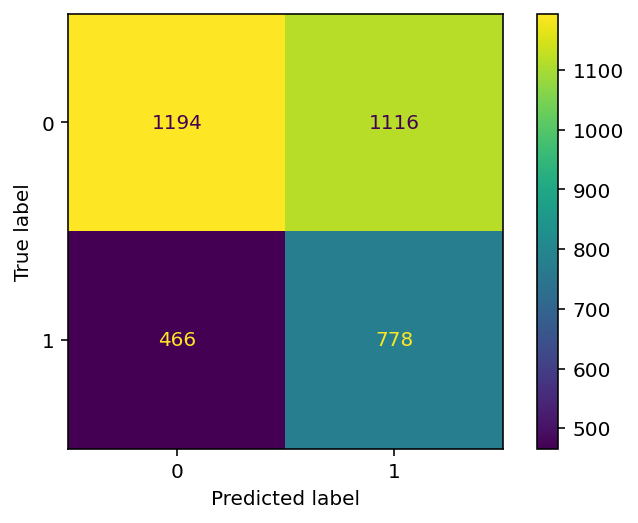

In [78]:
from sklearn import metrics

metrics.plot_confusion_matrix(pl, X_test, y_test);

### How well can our model generalize to unseen data using K-Folds cross validation?

In [83]:
## creating a K fold cross validation with 5 folds
kf=KFold(n_splits=5, shuffle=True)
score=cross_val_score(pl, X_train, y_train,cv=kf)

print("Average Cross Validation score :{}".format(score.mean()))

Average Cross Validation score :0.5968785431119485


# Final Model

### Creating the final dataset, we decide to keep only features we will be using in the final model

In [84]:
## Some minor cleaning of the data
final_data = merged3.drop(['state', 'add', 'owner_missing', \
                           'district', 'name', 'asset_description', \
                           'ticker'], axis=1)
final_data['party'] = final_data['party'].map(party_dict)
final_data['owner'] = final_data['owner'].fillna('None')
final_data = final_data.dropna()
final_data.head()

,disclosure_year,disclosure_date,transaction_date,owner,type,amount,cap_gains_over_200_usd,party
0,2021,2021-10-04,2021-09-27,joint,purchase,1000,False,1.0
1,2021,2021-10-04,2021-09-13,joint,purchase,1000,False,1.0
2,2021,2021-10-04,2021-09-10,joint,purchase,15000,False,1.0
3,2021,2021-10-04,2021-09-28,joint,purchase,15000,False,1.0
4,2021,2021-10-04,2021-09-17,self,sale_partial,1000,False,0.0


### Additional feature engineering. Here we make a new feature of time elapsed in days since opening and closing of stock trade. We also change boolean features to integers.

In [85]:
## Converting this column to pd.datetime object
final_data["transaction_date"] = pd.to_datetime\
(final_data['transaction_date'], errors='coerce')

## Calculating the difference in days between these 
## two columns to get new feature 'time_passed'
final_data['time_passed'] = (final_data['disclosure_date']\
                             - final_data["transaction_date"]).dt.days

## converting this boolean column to int column
final_data['cap_gains_over_200_usd'] = \
final_data['cap_gains_over_200_usd'].astype(int)

## Dropping date columns now they are no longer 
## needed after getting the time_passed column
final_data = final_data.drop(['disclosure_year', \
                              'disclosure_date', \
                              'transaction_date'], axis=1)


final_data = final_data.dropna()
final_data.head()

,owner,type,amount,cap_gains_over_200_usd,party,time_passed
0,joint,purchase,1000,0,1.0,7.0
1,joint,purchase,1000,0,1.0,21.0
2,joint,purchase,15000,0,1.0,24.0
3,joint,purchase,15000,0,1.0,6.0
4,self,sale_partial,1000,0,0.0,17.0


### Preprocessing the data by creating new features through one hot encoding and standardizing data

In [86]:
reproc = ColumnTransformer(
        transformers = [
            ## One hot encoding the categorical column 'type' and 'owner'
            ('ohe', OneHotEncoder(), ['type', 'owner']),
            ## Standardizing columns 'amount' and 'time_passed'
            ('std', StandardScaler(), ['amount', 'time_passed'])
        ]
    )

## We then can bundle the preprocessing pipline with a 
## K nearest neighbors model
pl = Pipeline([
        ('preprocessor', reproc), 
        ('model', KNeighborsClassifier())
    ])

### Performing train test split and fitting the data to the pipeline

In [87]:
## Setting X and y
X = final_data.drop(['party'], axis=1)
y = final_data.copy().loc[:, ['party']]
y = np.ravel(y)

## Train test split
X_train,X_test,y_train,y_test=train_test_split\
(X,y,test_size=0.25,random_state=0)
X_train.head()

,owner,type,amount,cap_gains_over_200_usd,time_passed
12609,self,sale_partial,1000,0,8.0
890,self,purchase,1000,0,9.0
12687,None,purchase,1000,0,35.0
7702,None,sale_partial,1000,0,47.0
7271,dependent,sale_partial,1000,0,246.0


### Setting a parameter grid and performing a grid search to find optimal parameter

In [88]:
## Grid of parameters to be fed into gridsearchCV
hyperparameters = {
    'model__n_neighbors': (1,5,10,20,50),
    'model__leaf_size': (20,40,1),
    'model__p': (1,2),
    'model__weights': ('uniform', 'distance')
}

## setting a gridsearch with 5 folds
searcher = GridSearchCV(pl, hyperparameters, cv=5)

searcher.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('ohe',
                                                                         OneHotEncoder(),
                                                                         ['type',
                                                                          'owner']),
                                                                        ('std',
                                                                         StandardScaler(),
                                                                         ['amount',
                                                                          'time_passed'])])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__leaf_size': (20, 40, 1),
                         'model__n_neighbors': (1, 5, 10, 20, 50),
                         'model__p': (

### Best Hyperparameters

In [89]:
print('Best Hyperparameters: %s' % searcher.best_params_)

Best Hyperparameters: {'model__leaf_size': 20, 'model__n_neighbors': 50, 'model__p': 1, 'model__weights': 'distance'}


### Making predictions on the data and getting back metrics

In [90]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

## Making predictions on X_test
predictions = searcher.predict(X_test)

## Here I created a small dataframe that contains 
## the models Accuracy, Precision, and Recall score
df_final = pd.DataFrame(index = ['K-Nearest Neighbors'], \
                        columns=['Accuracy', 'Precision', 'Recall'])
df_final['Accuracy'] = accuracy_score(predictions, y_test)
df_final['Precision'] = precision_score(predictions, y_test)
df_final['Recall'] = recall_score(predictions, y_test)
df_final

,Accuracy,Precision,Recall
K-Nearest Neighbors,0.803602,0.640675,0.760496


### Confusion matrix to visualize Positives and Negatives

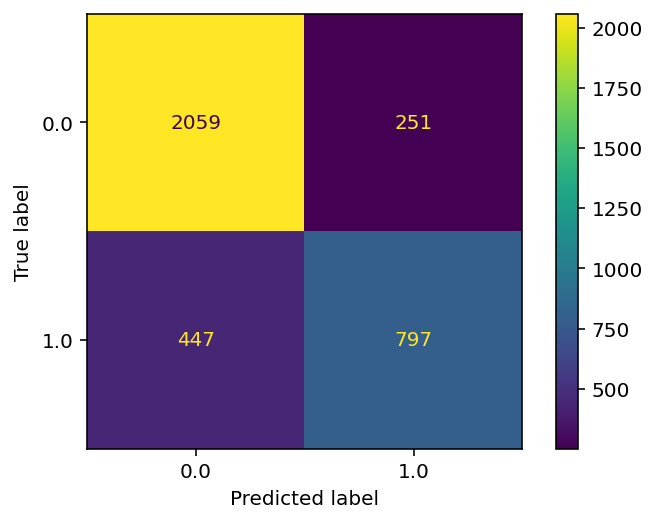

In [91]:
from sklearn import metrics

metrics.plot_confusion_matrix(searcher, X_test, y_test);

### How well can our model generalize to unseen data using K-Folds cross validation?

In [92]:
## creating a K fold cross validation with 5 folds
kf=KFold(n_splits=5, shuffle=True)
score=cross_val_score(searcher, X_train, y_train,cv=kf)

print("Average Cross Validation score :{}".format(score.mean()))

Average Cross Validation score :0.7896063292018833


# Fairness Analysis

### Creating a results dataframe to run our Fairness analysis

In [93]:
fairness_data = X_test.copy()
fairness_data['prediction'] = predictions
fairness_data['y_test'] = y_test
fairness_data.head()

,owner,type,amount,cap_gains_over_200_usd,time_passed,prediction,y_test
12536,joint,sale_full,1000,0,21.0,0.0,0.0
1094,None,sale_full,1000,1,27.0,0.0,1.0
2207,joint,sale_partial,1000,0,15.0,0.0,0.0
12189,joint,sale_partial,1000,0,11.0,0.0,0.0
14203,joint,sale_full,1000,0,23.0,0.0,1.0


### Here we binarize our amount traded feature with a threshold of 1 million dollars in stock purchased

In [94]:
fairness_data['purchase_size'] = (fairness_data.amount < 1000000)\
.replace({True: 'Small_purchase', False: 'Big_purchase'})

### Our observed difference in accuracy between our predicted political parties and our given political parties

In [95]:
observed = fairness_data.groupby('purchase_size')\
.apply(lambda x: metrics.accuracy_score(x['y_test'],\
                                        x['prediction'])).diff().iloc[-1]
observed

-0.00893866591294512

### Here we perform a simulation a 1000 times to get the difference in accuracy between our known data and the predicted data

In [96]:
## initialize array to append difference in accuracies
diff_in_acc = []
for i in range(1000):
    s = (
        fairness_data[['purchase_size', 'prediction', 'y_test']]
        .assign(purchase_size=fairness_data.purchase_size\
                .sample(frac=1.0, replace=False).reset_index(drop=True))
        .groupby('purchase_size')
        .apply(lambda x: metrics.accuracy_score(x['y_test'], x['prediction']))
        .diff()
        .iloc[-1]
    )
    
    diff_in_acc.append(s)

### Plotting our simulation

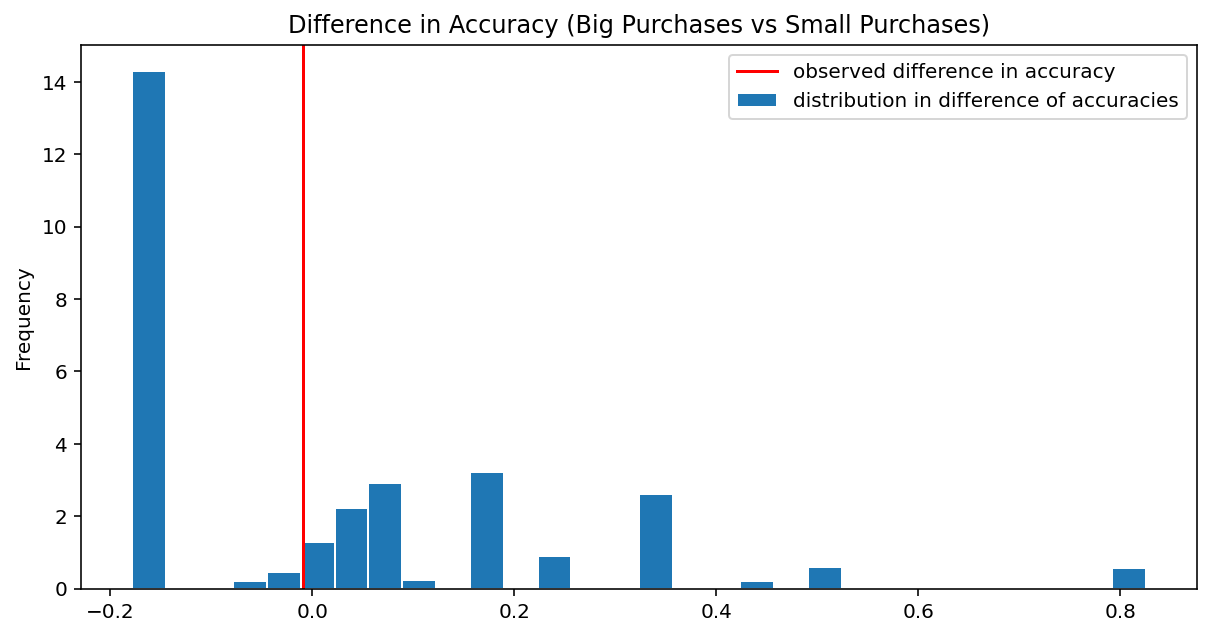

In [97]:
plt.figure(figsize=(10, 5))
pd.Series(diff_in_acc).plot\
(kind='hist', ec='w', density=True, bins=30, \
 title='Difference in Accuracy (Big Purchases vs Small Purchases)', \
 label='distribution in difference of accuracies')
plt.axvline(x=observed, color='red', label='observed difference in accuracy')
plt.legend(loc='upper right');

### Calculating P-Value

In [98]:
pvalue = (np.array(diff_in_acc) >= observed).mean()
pvalue

0.451

# Thank you for reading!